In [1]:
import netsquid as ns
from netsquid.protocols.nodeprotocols import *
from netsquid.util.datacollector import *
from netsquid.nodes.node import Node
from netsquid.components.models.qerrormodels import *
from netsquid.components.qprocessor import *
from netsquid.components.instructions import *
from netsquid.examples.teleportation import *
import pydynaa as pydynaa
from netsquid.protocols.protocol import *
from netsquid.components.component import *
from pydynaa.core import *
from netsquid.qubits import ketstates as ks
from netsquid.nodes.network import Network
from netsquid.components.models.qerrormodels import QuantumErrorModel
from netsquid.components.qprogram import QuantumProgram
import pandas as pandas
import numpy as np

print("This example module is located at: {}".format(
      ns.examples.repeater_chain.__file__))

This example module is located at: /root/.local/lib/python3.9/site-packages/netsquid/examples/repeater_chain.py


In [2]:
def create_qprocessor(name):
    """Factory to create a quantum processor for each node in the repeater chain network.

    Has two memory positions and the physical instructions necessary for teleportation.

    Parameters
    ----------
    name : str
        Name of the quantum processor.

    Returns
    -------
    :class:`~netsquid.components.qprocessor.QuantumProcessor`
        A quantum processor to specification.

    """
    noise_rate = 200
    gate_duration = 1
    gate_noise_model = DephaseNoiseModel(noise_rate)
    mem_noise_model = DepolarNoiseModel(noise_rate)
    physical_instructions = [
        PhysicalInstruction(INSTR_X, duration=gate_duration,
                            quantum_noise_model=gate_noise_model),
        PhysicalInstruction(INSTR_Z, duration=gate_duration,
                            quantum_noise_model=gate_noise_model),
        PhysicalInstruction(INSTR_MEASURE_BELL, duration=gate_duration),
    ]
    qproc = QuantumProcessor(name, num_positions=2, fallback_to_nonphysical=False,
                             mem_noise_models=[mem_noise_model] * 2,
                             phys_instructions=physical_instructions)
    return qproc

In [3]:

def setup_network(num_nodes, node_distance, source_frequency):
    """Setup repeater chain network.

    Parameters
    ----------
    num_nodes : int
        Number of nodes in the network, at least 3.
    node_distance : float
        Distance between nodes [km].
    source_frequency : float
        Frequency at which the sources create entangled qubits [Hz].

    Returns
    -------
    :class:`~netsquid.nodes.network.Network`
        Network component with all nodes and connections as subcomponents.

    """
    if num_nodes < 3:
        raise ValueError(f"Can't create repeater chain with {num_nodes} nodes.")
    network = Network("Repeater_chain_network")
    # Create nodes with quantum processors
    nodes = []
    for i in range(num_nodes):
        # Prepend leading zeros to the number
        num_zeros = int(np.log10(num_nodes)) + 1
        nodes.append(Node(f"Node_{i:0{num_zeros}d}", qmemory=create_qprocessor(f"qproc_{i}")))
    network.add_nodes(nodes)
    # Create quantum and classical connections:
    for i in range(num_nodes - 1):
        node, node_right = nodes[i], nodes[i + 1]
        # Create quantum connection
        qconn = EntanglingConnection(name=f"qconn_{i}-{i+1}", length=node_distance,
                                     source_frequency=source_frequency)
        # Add a noise model which depolarizes the qubits exponentially
        # depending on the connection length
        for channel_name in ['qchannel_C2A', 'qchannel_C2B']:
            qconn.subcomponents[channel_name].models['quantum_noise_model'] =\
                FibreDepolarizeModel()
        port_name, port_r_name = network.add_connection(
            node, node_right, connection=qconn, label="quantum")
        # Forward qconn directly to quantum memories for right and left inputs:
        node.ports[port_name].forward_input(node.qmemory.ports["qin0"])  # R input
        node_right.ports[port_r_name].forward_input(
            node_right.qmemory.ports["qin1"])  # L input
        # Create classical connection
        cconn = ClassicalConnection(name=f"cconn_{i}-{i+1}", length=node_distance)
        port_name, port_r_name = network.add_connection(
            node, node_right, connection=cconn, label="classical",
            port_name_node1="ccon_R", port_name_node2="ccon_L")
        # Forward cconn to right most node
        if "ccon_L" in node.ports:
            node.ports["ccon_L"].bind_input_handler(
                lambda message, _node=node: _node.ports["ccon_R"].tx_output(message))
    return network

In [4]:

class FibreDepolarizeModel(QuantumErrorModel):
    """Custom non-physical error model used to show the effectiveness
    of repeater chains.

    The default values are chosen to make a nice figure,
    and don't represent any physical system.

    Parameters
    ----------
    p_depol_init : float, optional
        Probability of depolarization on entering a fibre.
        Must be between 0 and 1. Default 0.009
    p_depol_length : float, optional
        Probability of depolarization per km of fibre.
        Must be between 0 and 1. Default 0.025

    """

    def __init__(self, p_depol_init=0.009, p_depol_length=0.025):
        super().__init__()
        self.properties['p_depol_init'] = p_depol_init
        self.properties['p_depol_length'] = p_depol_length
        self.required_properties = ['length']

    def error_operation(self, qubits, delta_time=0, **kwargs):
        """Uses the length property to calculate a depolarization probability,
        and applies it to the qubits.

        Parameters
        ----------
        qubits : tuple of :obj:`~netsquid.qubits.qubit.Qubit`
            Qubits to apply noise to.
        delta_time : float, optional
            Time qubits have spent on a component [ns]. Not used.

        """
        for qubit in qubits:
            prob = 1 - (1 - self.properties['p_depol_init']) * np.power(
                10, - kwargs['length']**2 * self.properties['p_depol_length'] / 10)
            ns.qubits.depolarize(qubit, prob=prob)

In [5]:
def setup_repeater_protocol(network):
    """Setup repeater protocol on repeater chain network.

    Parameters
    ----------
    network : :class:`~netsquid.nodes.network.Network`
        Repeater chain network to put protocols on.

    Returns
    -------
    :class:`~netsquid.protocols.protocol.Protocol`
        Protocol holding all subprotocols used in the network.

    """
    protocol = LocalProtocol(nodes=network.nodes)
    # Add SwapProtocol to all repeater nodes. Note: we use unique names,
    # since the subprotocols would otherwise overwrite each other in the main protocol.
    nodes = [network.nodes[name] for name in sorted(network.nodes.keys())]
    for node in nodes[1:-1]:
        subprotocol = SwapProtocol(node=node, name=f"Swap_{node.name}")
        protocol.add_subprotocol(subprotocol)
    # Add CorrectProtocol to Bob
    subprotocol = CorrectProtocol(nodes[-1], len(nodes))
    protocol.add_subprotocol(subprotocol)
    return protocol

In [6]:

class SwapProtocol(NodeProtocol):
    """Perform Swap on a repeater node.

    Parameters
    ----------
    node : :class:`~netsquid.nodes.node.Node` or None, optional
        Node this protocol runs on.
    name : str
        Name of this protocol.

    """

    def __init__(self, node, name):
        super().__init__(node, name)
        self._qmem_input_port_l = self.node.qmemory.ports["qin1"]
        self._qmem_input_port_r = self.node.qmemory.ports["qin0"]
        self._program = QuantumProgram(num_qubits=2)
        q1, q2 = self._program.get_qubit_indices(num_qubits=2)
        self._program.apply(INSTR_MEASURE_BELL, [q1, q2], output_key="m", inplace=False)

    def run(self):
        while True:
            yield (self.await_port_input(self._qmem_input_port_l) &
                   self.await_port_input(self._qmem_input_port_r))
            # Perform Bell measurement
            yield self.node.qmemory.execute_program(self._program, qubit_mapping=[1, 0])
            m, = self._program.output["m"]
            # Send result to right node on end
            self.node.ports["ccon_R"].tx_output(Message(m))

In [7]:
class CorrectProtocol(NodeProtocol):
    """Perform corrections for a swap on an end-node.

    Parameters
    ----------
    node : :class:`~netsquid.nodes.node.Node` or None, optional
        Node this protocol runs on.
    num_nodes : int
        Number of nodes in the repeater chain network.

    """

    def __init__(self, node, num_nodes):
        super().__init__(node, "CorrectProtocol")
        self.num_nodes = num_nodes
        self._x_corr = 0
        self._z_corr = 0
        self._program = SwapCorrectProgram()
        self._counter = 0

    def run(self):
        while True:
            yield self.await_port_input(self.node.ports["ccon_L"])
            message = self.node.ports["ccon_L"].rx_input()
            if message is None or len(message.items) != 1:
                continue
            m = message.items[0]
            if m == ks.BellIndex.B01 or m == ks.BellIndex.B11:
                self._x_corr += 1
            if m == ks.BellIndex.B10 or m == ks.BellIndex.B11:
                self._z_corr += 1
            self._counter += 1
            if self._counter == self.num_nodes - 2:
                if self._x_corr or self._z_corr:
                    self._program.set_corrections(self._x_corr, self._z_corr)
                    yield self.node.qmemory.execute_program(self._program, qubit_mapping=[1])
                self.send_signal(Signals.SUCCESS)
                self._x_corr = 0
                self._z_corr = 0
                self._counter = 0

In [8]:

class SwapCorrectProgram(QuantumProgram):
    """Quantum processor program that applies all swap corrections."""
    default_num_qubits = 1

    def set_corrections(self, x_corr, z_corr):
        self.x_corr = x_corr % 2
        self.z_corr = z_corr % 2

    def program(self):
        q1, = self.get_qubit_indices(1)
        if self.x_corr == 1:
            self.apply(INSTR_X, q1)
        if self.z_corr == 1:
            self.apply(INSTR_Z, q1)
        yield self.run()

In [9]:
def setup_datacollector(network, protocol):
    """Setup the datacollector to calculate the fidelity
    when the CorrectionProtocol has finished.

    Parameters
    ----------
    network : :class:`~netsquid.nodes.network.Network`
        Repeater chain network to put protocols on.

    protocol : :class:`~netsquid.protocols.protocol.Protocol`
        Protocol holding all subprotocols used in the network.

    Returns
    -------
    :class:`~netsquid.util.datacollector.DataCollector`
        Datacollector recording fidelity data.

    """
    # Ensure nodes are ordered in the chain:
    nodes = [network.nodes[name] for name in sorted(network.nodes.keys())]

    def calc_fidelity(evexpr):
        qubit_a, = nodes[0].qmemory.peek([0])
        qubit_b, = nodes[-1].qmemory.peek([1])
        fidelity = ns.qubits.fidelity([qubit_a, qubit_b], ks.b00, squared=True)
        return {"fidelity": fidelity}

    dc = DataCollector(calc_fidelity, include_entity_name=False)
    dc.collect_on(pydynaa.EventExpression(source=protocol.subprotocols['CorrectProtocol'],
                                          event_type=Signals.SUCCESS.value))
    return dc

In [10]:
def run_simulation(num_nodes=4, node_distance=20, num_iters=100):
    """Run the simulation experiment and return the collected data.

    Parameters
    ----------
    num_nodes : int, optional
        Number nodes in the repeater chain network. At least 3. Default 4.
    node_distance : float, optional
        Distance between nodes, larger than 0. Default 20 [km].
    num_iters : int, optional
        Number of simulation runs. Default 100.

    Returns
    -------
    :class:`pandas.DataFrame`
        Dataframe with recorded fidelity data.

    """
    ns.sim_reset()
    est_runtime = (0.5 + num_nodes - 1) * node_distance * 5e3
    network = setup_network(num_nodes, node_distance=node_distance,
                            source_frequency=1e9 / est_runtime)
    protocol = setup_repeater_protocol(network)
    dc = setup_datacollector(network, protocol)
    protocol.start()
    ns.sim_run(est_runtime * num_iters)
    return dc.dataframe

In [31]:

def create_plot(num_iters=2):
    """Run the simulation for multiple nodes and distances and show them in a figure.

    Parameters
    ----------

    num_iters : int, optional
        Number of iterations per simulation configuration.
        At least 1. Default 2000.
    """
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots()
    for distance in [5, 30, 500]:
        data = pandas.DataFrame()
        for num_node in range(3, 30):
            data[num_node] = run_simulation(num_nodes=num_node,
                                            node_distance=distance / num_node,
                                            num_iters=num_iters)['fidelity']
        # For errorbars we use the standard error of the mean (sem)
        data = data.agg(['mean', 'sem']).T.rename(columns={'mean': 'fidelity'})
        data.plot(y='fidelity', yerr='sem', label=f"{distance} km", ax=ax)
    plt.xlabel("number of nodes")
    plt.ylabel("fidelity")
    plt.title("Repeater chain with different total lengths")

    plt.show()

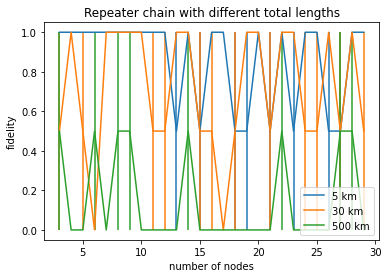

<Figure size 3600x288 with 0 Axes>

In [32]:
create_plot()